
# Обучение без учителя. Кластеризация

Интуитивная постановка задачи кластеризации довольно проста и представляет из себя наше желание сказать: "Вот тут у меня насыпаны точки. Я вижу, что они сваливаются в какие-то кучки вместе. Было бы круто иметь возможность эти точки относить к кучкам и в случае появления новой точки на плоскости говорить, в какую кучку она падает." Из такой постановки видно, что пространства для фантазии получается много, и от этого возникает соответствующее множество алгоритмов решения этой задачи. Перечисленные алгоритмы ни в коем случае не описывают данное множество полностью, но являются примерами самых популярных методов решения задачи кластеризации.

Картинка взята с сайта https://scikit-learn.org/stable/modules/clustering.html
![Clustering_methods](img/clustering.png)

---


### K-means

Алгоритм К-means один из самых популярных алгоритмов кластеризации и очень легко представляется в виде простого псевдокода:

1. Выбрать количество кластеров, которое кажется оптимальным для данных.
2. Сгенерировать случайным образом в пространство наших данных  точек (центроидов).
3. Для каждой точки набора данных посчитать, к какому центроиду она ближе.
4. Переместить каждый центроид в центр выборки, которую отнесли к этому центроиду.
5. Повторять последние два шага фиксированное число раз, либо до тех пор пока центроиды не "сойдутся" (обычно это значит, что их смещение относительно предыдущего положения не превышает какого-то заранее заданного небольшого значения).

В случае обычной евклидовой метрики для точек лежащих на плоскости, этот алгоритм очень просто расписывается аналитически и рисуется.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.datasets import make_circles
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering
from sklearn.decomposition import PCA

# функция, которая считает расстояния между парами точек из двух массивов
from scipy.spatial.distance import cdist

> # Задание
>
>При помощи функции `make_blobs` создайте набор точек из 500 примеров, 3 центра, размерность признакового пространства = 2, random_state = 42. Отобразите эти данные.

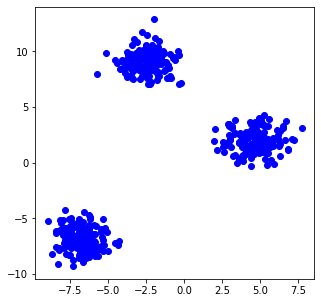

In [2]:
# Сгенерируем и визуализируем точки


> # Задание
>
> Реализовать алгоритм K-means для 3-х итераций и сохранить историю, чтобы в дальнейшем визуализировать эволюцию работы алгоритма

In [ ]:
# type your code here

Также стоит заметить, что хоть мы и рассматривали **евклидово расстояние**, алгоритм будет сходиться и в случае любой другой метрики, поэтому для различных задач кластеризации в зависимости от данных можно экспериментировать не только с количеством шагов или критерием сходимости, но и с метрикой, по которой мы считаем расстояния между точками и центроидами кластеров.


Другой особенностью этого алгоритма является то, что он чувствителен к исходному положению центроид кластеров в пространстве. В такой ситуации спасает несколько последовательных запусков алгоритма с последующим усреднением полученных кластеров.

В отличие от задачи классификации или регресии, в случае кластеризации сложнее выбрать критерий, с помощью которого было бы просто представить задачу кластеризации как задачу оптимизации.
В случае `k-Means` распространен вот такой критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся.

$$ J(C) = \sum_{k=1}^{K} \sum_{i \leq C_{k}} ||x_{i}-\mu_{k}||^2 \ \to \ \min_{k} $$

здесь $ C $ – множество кластеров мощности $ K $, $ \mu_{k} $ – центроид кластера $ C_{k} $.


Понятно, что здравый смысл в этом есть: мы хотим, чтобы точки располагались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента).
Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". **Или более формально:**

$$ D(k) = \frac{|J(C_{k}-J(C_{k+1}|}{|J(C_{k}|} \to \min_{k} $$

## Что-что?

In [ ]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(10,6), tight_layout=True)
plt.grid(True)
plt.plot(range(1, 8), inertia, 'o-c', linewidth=2);
plt.xlabel('$k$')
plt.ylabel('$J(C_{k})$');

In [ ]:
# Также для выделения оптимального набора параметров, можно воспользоватся библиотекой KElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(kmeans, k=(1,7), metric = 'distortion', timings = False);
visualizer.fit(X);
visualizer.show();

Видим, что  падает сильно при увеличении числа кластеров с $ 1 $ до $ 2 $ и с $ 2 $ до $ 3 $ и уже не так сильно – при изменении  с $ 3 $ до $ 4 $. Значит, в данной задаче оптимально задать **3** кластера.

---

### Все ли так просто?

Само по себе решение задачи `K-means` `NP-трудное (NP-hard)`, и для размерности $ d $, числа кластеров $ k $ и числа точек $ n $ решается за $ O(n^{dk+1}) $. Для решения такой боли часто используются эвристики, например `MiniBatch K-means`, который для обучения использует не весь датасет целиком, а лишь маленькие его порции (batch) и обновляет центроиды используя среднее за всю историю обновлений центроида от всех относящихся к нему точек. Сравнение обычного `K-means` и его `MiniBatch` имплементации можно посмотреть в документации `scikit-learn`.


Реализация алгоритма в `scikit-learn` обладает массой удобных плюшек, таких как возможность задать количество запусков через параметр `n_init`, что даст более устойчивые центроиды для кластеров в случае скошенных данных. К тому же эти запуски можно делать параллельно, не жертвуя временем вычисления.


> # Задание
>
> Для нового набора данных `X_mnist_tsne`, полученного при помощи снижения размерности, определите наиболее оптимальное количество кластеров при работе алгоритма `K-Means`. Про алгоритмы снижения размерности мы поговорим в следующем занятии, сейчас просто рассматриваем как признаковое пространство, для которого необходимо реализовать кластеризацию.

In [ ]:
# загрузим данные по цифрам
digits = datasets.load_digits()
X_mnist = digits.data
y_mnist = digits.target

# Создадим объект TSNE
tSNE_mnist = TSNE(random_state=17)

# настройка модели
X_mnist_tsne = tSNE_mnist.fit_transform(X_mnist)

# визуализация данных
plt.figure(figsize=(15,12))
plt.scatter(X_mnist_tsne[:, 0], X_mnist_tsne[:, 1], c=y_mnist, 
            edgecolor='none', alpha=0.5, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE');

In [ ]:
# Оптимальное количество кластеров для MNIST
# type your code here